In [1]:
import numpy as np
import pandas as pd

import torch

In [2]:
X_df= pd.read_json('mydata-mitbih-small.json')

In [3]:
X_df.shape

(5000, 2001)

In [4]:
X_data = np.array(X_df.sample(frac=1))
X_data = X_data[:,:-1]
Y_data = X_data[:,-1]
Y_data = 1.*(Y_data > 0.)

In [5]:
N = 4000

In [6]:
Y = Y_data[:N]
X = X_data[:N]
Xtest = X_data[N:]
Ytest = Y_data[N:]

In [7]:
X = torch.FloatTensor(X)
Y = torch.FloatTensor(Y)
Xtest = torch.FloatTensor(Xtest)
Ytest = torch.FloatTensor(Ytest)
Y.shape

torch.Size([4000])

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the model
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x

# # Create sample data
# # Assuming X is of shape (num_samples, input_size) and Y is (num_samples, 1)
# X = torch.randn(100, 10)  # Example input tensor
# Y = torch.randint(0, 2, (100, 1)).float()  # Example binary output tensor


In [9]:

# Hyperparameters
input_size = X.shape[1]
hidden_size = 128
output_size = 1
num_epochs = 100
batch_size = 16
learning_rate = 0.001

# Create dataset and dataloader
dataset = TensorDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss function, and optimizer
model = SimpleNN(input_size, hidden_size, output_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for batch_X, batch_Y in dataloader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y.unsqueeze(-1))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training complete.")


Epoch [10/100], Loss: 0.0104
Epoch [20/100], Loss: 0.0007
Epoch [30/100], Loss: 0.0000
Epoch [40/100], Loss: 0.0000
Epoch [50/100], Loss: 0.5299
Epoch [60/100], Loss: 0.0008
Epoch [70/100], Loss: 0.0001
Epoch [80/100], Loss: 0.0000
Epoch [90/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0000
Training complete.


In [10]:
model.eval()


SimpleNN(
  (hidden): Linear(in_features=2000, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [11]:
test_outputs = model(Xtest)
test_outputs = torch.sigmoid(test_outputs)


In [12]:
predicted = (test_outputs > 0.5).float()


In [13]:
correct = (predicted.squeeze() == Ytest).sum().item()
total = Ytest.size(0)
accuracy = correct / total

In [14]:
total

1000

In [15]:
Ytest.mean()

tensor(0.3720)

In [16]:
accuracy

0.894

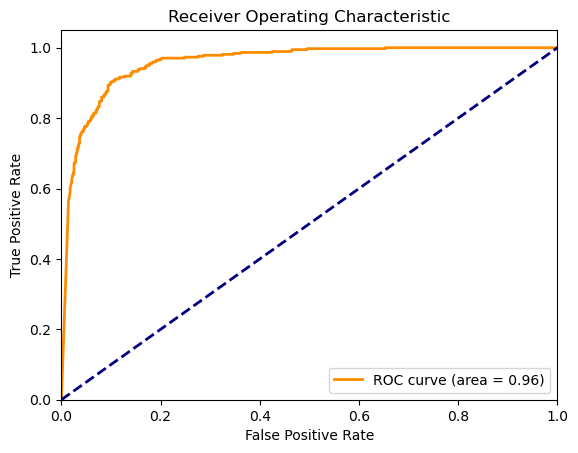

In [17]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# # Assuming Xtest and Ytest are your test tensors
# Xtest = torch.randn(20, input_size)  # Example test input tensor
# Ytest = torch.randint(0, 2, (20, 1)).float()  # Example test output tensor

# Set the model to evaluation mode
model.eval()

# No gradient computation needed for evaluation
with torch.no_grad():
    # Forward pass
    test_outputs = model(Xtest)
    test_outputs = torch.sigmoid(test_outputs).squeeze()  # Apply sigmoid to get probabilities

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(Ytest.numpy(), test_outputs.numpy())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Using Fourier

In [18]:
# Perform Fourier transform
X_fft = torch.fft.fft(X, dim=1)

# Separate real and imaginary parts
X_real = X_fft.real
X_imag = X_fft.imag

# Alternatively, compute magnitude and phase
X_mag = torch.abs(X_fft)
X_phase = torch.angle(X_fft)

# Combine real and imaginary parts as channels (or magnitude and phase)
X_combined = torch.cat((X_real, X_imag), dim=1)
# Or
# X_combined = torch.cat((X_mag, X_phase), dim=1)

In [19]:
Xtest_fft = torch.fft.fft(Xtest, dim=1)
# Separate real and imaginary parts
Xtest_real = Xtest_fft.real
Xtest_imag = Xtest_fft.imag

# Combine real and imaginary parts as channels (or magnitude and phase)
Xtest_combined = torch.cat((Xtest_real, Xtest_imag), dim=1)

In [20]:
# Hyperparameters
input_size = X_combined.shape[1]
hidden_size = 128
output_size = 1
num_epochs = 100
batch_size = 16
learning_rate = 0.001

# Create dataset and dataloader
dataset = TensorDataset(X_combined, Y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss function, and optimizer
model = SimpleNN(input_size, hidden_size, output_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for batch_X, batch_Y in dataloader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y.unsqueeze(-1))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training complete.")


Epoch [10/100], Loss: 0.0580
Epoch [20/100], Loss: 0.0009
Epoch [30/100], Loss: 0.0000
Epoch [40/100], Loss: 0.0000
Epoch [50/100], Loss: 0.0000
Epoch [60/100], Loss: 0.0000
Epoch [70/100], Loss: 0.0000
Epoch [80/100], Loss: 0.0000
Epoch [90/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0000
Training complete.


In [21]:
model.eval()
with torch.no_grad():
    test_outputs = model(Xtest_combined)
test_outputs = torch.sigmoid(test_outputs)
predicted = (test_outputs > 0.5).float()
correct = (predicted.squeeze() == Ytest).sum().item()
total = Ytest.size(0)
accuracy = correct / total
accuracy

0.872

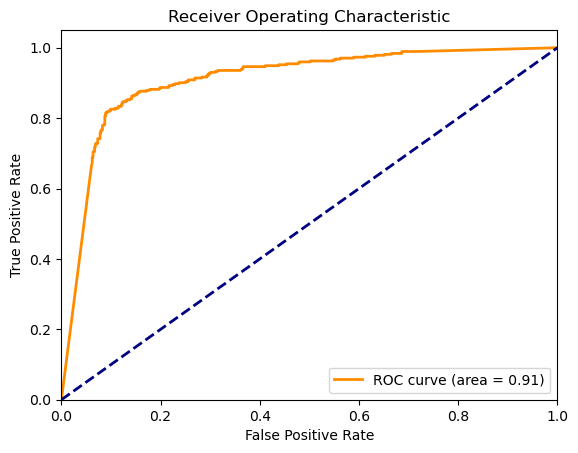

In [22]:
# Set the model to evaluation mode
model.eval()

# No gradient computation needed for evaluation
with torch.no_grad():
    # Forward pass
    test_outputs = model(Xtest_combined)
    test_outputs = torch.sigmoid(test_outputs).squeeze()  # Apply sigmoid to get probabilities

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(Ytest.numpy(), test_outputs.numpy())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Time + Fourier

In [23]:
X_fftime =  torch.cat([X,X_combined],axis=1)
Xtest_fftime =  torch.cat([Xtest,Xtest_combined],axis=1)

In [24]:
# Hyperparameters
input_size = X_fftime.shape[1]
hidden_size = 128
output_size = 1
num_epochs = 100
batch_size = 16
learning_rate = 0.001

# Create dataset and dataloader
dataset = TensorDataset(X_fftime, Y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss function, and optimizer
model = SimpleNN(input_size, hidden_size, output_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for batch_X, batch_Y in dataloader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y.unsqueeze(-1))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training complete.")


Epoch [10/100], Loss: 0.2797
Epoch [20/100], Loss: 0.0073
Epoch [30/100], Loss: 0.0000
Epoch [40/100], Loss: 0.0000
Epoch [50/100], Loss: 0.0000
Epoch [60/100], Loss: 0.0000
Epoch [70/100], Loss: 0.0000
Epoch [80/100], Loss: 0.0000
Epoch [90/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0000
Training complete.


In [25]:
model.eval()
with torch.no_grad():
    test_outputs = model(Xtest_fftime)
test_outputs = torch.sigmoid(test_outputs)
predicted = (test_outputs > 0.5).float()
correct = (predicted.squeeze() == Ytest).sum().item()
total = Ytest.size(0)
accuracy = correct / total
accuracy

0.885

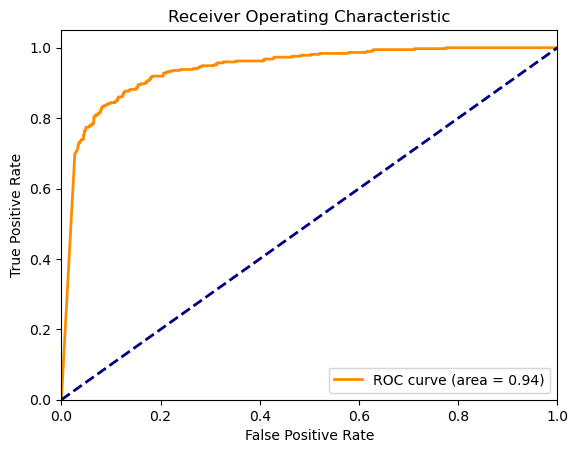

In [26]:
# Set the model to evaluation mode
model.eval()

# No gradient computation needed for evaluation
with torch.no_grad():
    # Forward pass
    test_outputs = model(Xtest_fftime)
    test_outputs = torch.sigmoid(test_outputs).squeeze()  # Apply sigmoid to get probabilities

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(Ytest.numpy(), test_outputs.numpy())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [27]:
# stop

In [28]:
import pymultifracs.psd as psd

fs = 1

c:\Users\aejog\anaconda3\Lib\site-packages\scipy\signal\_signaltools.py:278: RuntimeWarning: invalid value encountered in cast
  z = _sigtools._correlateND(in1zpadded, in2, out, val)


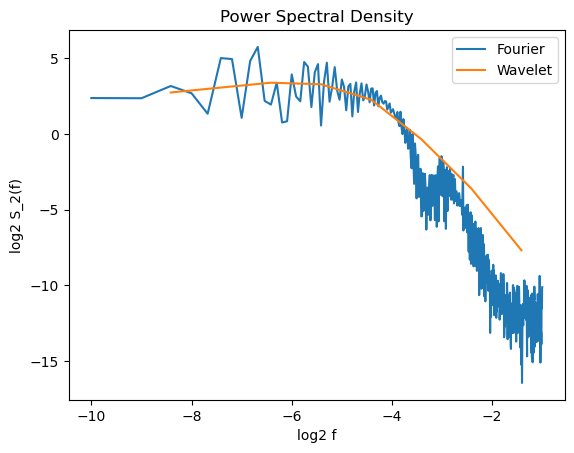

In [29]:
rand_int = np.random.randint(N)
psd.plot_psd(X[rand_int], fs, n_fft=1024)

In [30]:
import pymultifracs.mfa as mfa
from pymultifracs.utils import build_q_log

In [31]:
dwt, lwt = mfa.mf_analysis_full(X[rand_int],
    scaling_ranges = [[1,7]],
    q = build_q_log(1, 10, 20),
    n_cumul=2,
    p_exp=np.inf,
    gamint=0.0
)

c:\Users\aejog\anaconda3\Lib\site-packages\scipy\signal\_signaltools.py:278: RuntimeWarning: invalid value encountered in cast
  z = _sigtools._correlateND(in1zpadded, in2, out, val)


In [32]:
lwt_sf, lwt_cumul, lwt_mfs, hmin = lwt

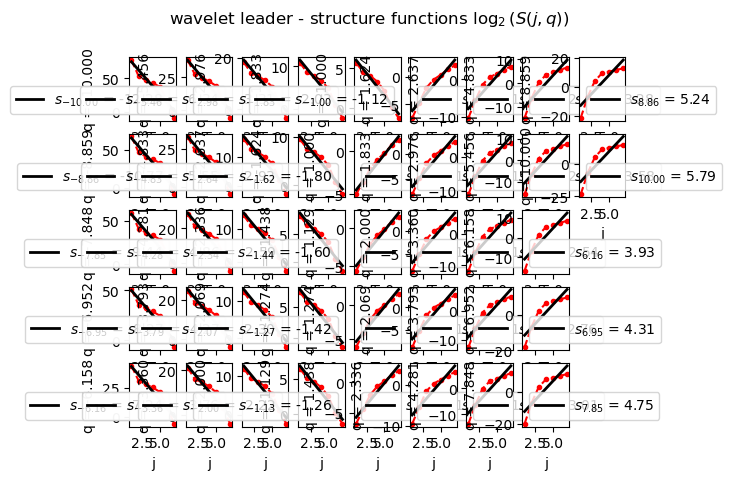

In [33]:
lwt_sf.plot(nrow=5)

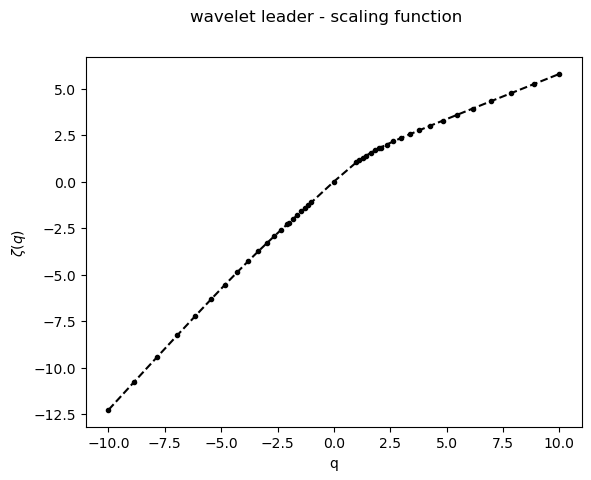

In [34]:
lwt_sf.plot_scaling()

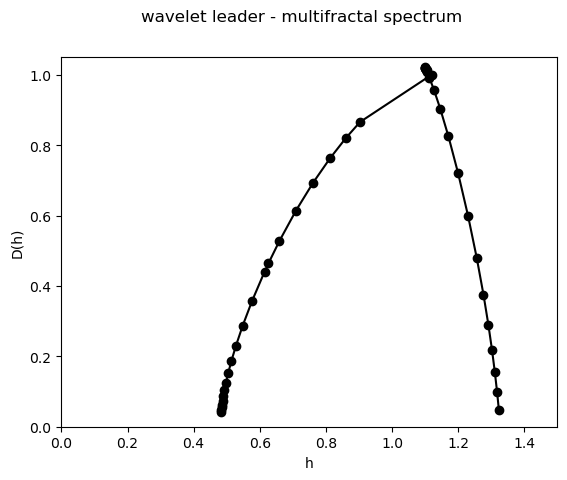

In [35]:
lwt_mfs.plot()